## The Neural Network
It's the same architecture as in the class tutorial for now but with slightly bigger layers.  We can play around more with different number/size/type of layers.

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class My_Neural_Net(nn.Module):    
    def __init__(self, len):
        super(My_Neural_Net, self).__init__()
        
        self.layer_1 = nn.Linear(len, 10)
        self.layer_2 = nn.Linear(10,50)
        self.layer_3 = nn.Linear(50,1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        
    def forward(self, X):
        X = self.layer_1(X)
        X = self.relu(X)
        X = self.layer_2(X)
        X = self.relu(X)
        X = self.layer_3(X)
        X = self.sigmoid(X)
        
        return X
    
    def loss(self, pred, true):
        score = nn.L1Loss()
        return score(pred, true)
    

    def fit(self,X,y,N = 500):
        
        for epoch in range(N):
            
            self.optimizer.zero_grad()
            
            pred = self.forward(X)
                        
            l = self.loss(pred, y)
            
            #print loss
            #print(l)
            
            l.backward()
            self.optimizer.step()
    
    def predict(self, X):
        probs = self.forward(X)
        
        return probs
    
    def score(self, X, y):
        acc = ((self.predict(X) - y.float())*(self.predict(X) - y.float())).mean()
        return acc

## Parsing the data
The input data is in a bit of a weird format, so I wrote some functions to parse it.  Right now I have it reading in but not using the graph dat, but we can change that later as we test example from different TSP instances than we trained on.

In [3]:
import re
import math
import matplotlib.pyplot as plt

def dist(xs, ys, i, j):
    dx = xs[j] - xs[i]
    dy = ys[j] - ys[i]
    return math.sqrt(dx*dx+dy*dy)

def formatData(dataFiles, graphFn):
    with open(graphFn) as f:
        nodeCoords = False
        edgeList = False
        xs = []
        ys = []
        for line in f:
            if 'EOF' in line:
                break
            elif nodeCoords:
                tokens = line.split()
                xs.append(float(tokens[1]))
                ys.append(float(tokens[2]))
            elif 'NODE_COORD_SECTION' in line:
                nodeCoords = True
    
    n = len(xs)
    trainingPoints = []
    answers = []
    
    for dataFile in dataFiles:
        rhs = []
        mat = []
        outputMap = dict()
        maxIndex = 0
        with open(dataFile) as f:
            for line in f:
                if 'hi' in line:
                    continue
                if len(line) == 0:
                    continue
                floats = [float(s) for s in re.findall(r'-?\d+\.?\d*', line)]
                if line[0] == 'c':
                    if len(floats) != 2:
                        continue
                    rhs.append(floats[1])
                elif 'Coefficients' in line:
                    if len(floats) == 0:
                        continue
                    mat.append(floats)
                    for i in range(0, len(floats), 2):
                        maxIndex = max(maxIndex, int(floats[i]))
                else:
                    tokens = line.split()
                    outputMap[int(tokens[0])] = float(tokens[1])
        colTot = []
        for col in mat:
            curColTot = 0.0
            for i in range(0, len(col), 2):
                #rowTot[int(col[i])] += float(col[i+1])
                curColTot += float(col[i+1])
                colTot.append(curColTot)
        for x in outputMap:
            curPoint = []
            #for i in range(0, n):
            #    curPoint.append(xs[i])
            #    curPoint.append(ys[i])
            for col in mat:
                found = False
                for j in range(0, len(col), 2):
                    if col[j] == x:
                        found = True
                        curPoint.append(col[j+1])
                    if not found:
                        curPoint.append(0.0)
            trainingPoints.append(curPoint)
            answers.append([outputMap[x]])
            
    return trainingPoints, answers

name='att532'

trainFiles = ['../data_'+name+'.tsp_output/file0.txt',
                     '../data_'+name+'.tsp_output/file1.txt', 
                     '../data_'+name+'.tsp_output/file2.txt',
                     '../data_'+name+'.tsp_output/file3.txt']

testFiles = ['../data_'+name+'.tsp_output/file4.txt']
    
                
xs, ys = formatData(trainFiles, '../data/'+name+'.tsp')
tests = [formatData([i], '../data/'+name+'.tsp') for i in testFiles]
xstests = [tests[i][0] for i in range(0, len(tests))]
ystests = [tests[i][1] for i in range(0, len(tests))]
maxLen = 0
for x in xs:
    maxLen = max(maxLen, len(x))
    
for xstest in xstests:
    for x in xstest:
        maxLen = max(maxLen, len(x))
    
for x in xs:
    while(len(x) < maxLen):
        x.append(0.0)
        
for xstest in xstests:
    for x in xstest:
        while(len(x) < maxLen):
            x.append(0.0)

## Additional Comprison Metrics
For now I just have Spearman correlation for ranking-based analysis, but it has some shortcomings so I want to try different things.

In [4]:
from sklearn.preprocessing import normalize
import numpy as np
from scipy.stats import spearmanr

def overlap(a, b):
    res = 0
    for x in a:
        if x in b:
            res += 1
    return res

def compareRankings(y, pred):
    print(spearmanr(y, [pred[i][0] for i in range(0, len(pred))]))

## Code for Plotting
Plot historgrams of the distribution we are predicting, as well as a scatterplot to see how our predictions correlate with the truth.

In [5]:
buckets = [0.01 * i for i in range(5, 55)]

def plotPreds(y_train, trainpreds, nn, test = False):
    ydata = [y_train[i][0] for i in range(0, len(y_train))]
    trainpredsdata = [trainpreds.numpy()[i][0] for i in range(0, len(trainpreds))]
    plt.hist(ydata, bins = buckets)
    plt.xlabel('Node value')
    plt.ylabel('Number of nodes')
    plt.title('Training Data: Node Values to Predict')
    if test:
         plt.title('Testing Data: Node Values to Predict')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    plt.scatter(trainpredsdata, ydata)
    plt.title('Training Data Predictions')
    if test:
         plt.title('Testing Data Predictions')
    plt.xlabel('Predicted node value')
    plt.ylabel('Actual node value')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    plt.hist(trainpredsdata, bins = buckets)
    plt.xlabel('Node value')
    plt.ylabel('Number of nodes')
    plt.title('Training Data: Predicted Node Values')
    if test:
        plt.title('Testing Data: Predicted Node Values')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()


    if not test:
        print('Training score:')
    else:
        print('Testing score:')
    trainingScore = nn.score(X_train_tens,y_train_tens)
    print(trainingScore)
    compareRankings(trainpreds.numpy(), y_train)


## Training Data Analysis
Training the neural network and plotting how well it performs on the training data.  Good performance here is good but could also indicate overfitting so take with a grain of salt.

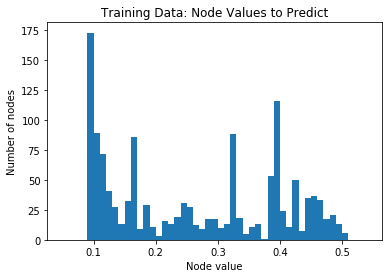

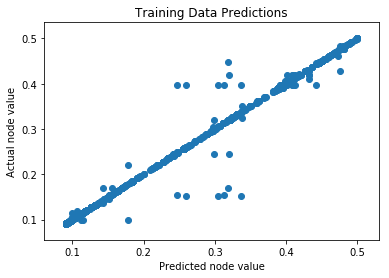

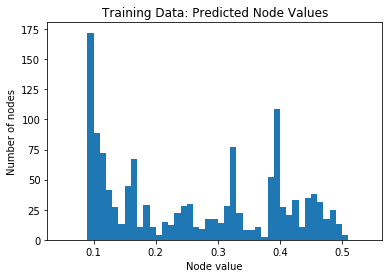

Training score:
tensor(0.0002, grad_fn=<MeanBackward1>)
SpearmanrResult(correlation=0.9953243481517251, pvalue=0.0)


In [6]:
X_train, y_train = xs, ys

X_train = normalize(X_train)

X_train_tens = Variable(torch.Tensor(X_train).float())
y_train_tens = Variable(torch.Tensor(y_train).float())

neur_net = My_Neural_Net(len(xs[0]))

neur_net.fit(X_train_tens,y_train_tens)
trainpreds = neur_net.predict(X_train_tens).detach()
plotPreds(y_train, trainpreds, neur_net)

## Test Data Analysis - same instance, different branching occasions
How well the model performs when training data comes from other branches within the same instance.  This means the graph is the same but the LP matrix is different.

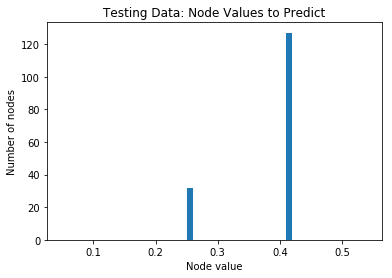

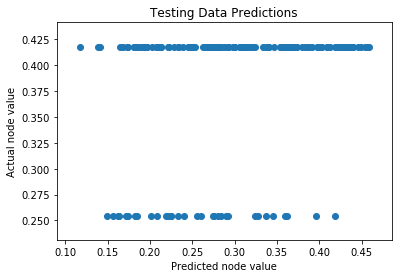

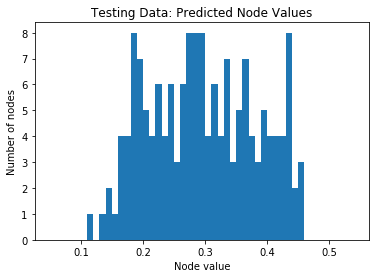

Testing score:
tensor(0.0002, grad_fn=<MeanBackward1>)
SpearmanrResult(correlation=0.24025949704841543, pvalue=0.002284884414362929)


In [7]:
for testIndex in range(0, len(xstests)):
    xstest = xstests[testIndex]
    ystest = ystests[testIndex]
    X_test, y_test = xstest, ystest
    X_test = normalize(X_test)
    X_test_tens = Variable(torch.Tensor(X_test).float())
    y_test_tens = Variable(torch.Tensor(y_test).float())
    testpreds = neur_net.predict(X_test_tens).detach()
    plotPreds(y_test, testpreds, neur_net, True)

## Test Data Analysis - same instance, same branching occasions
How well the model performs when training data comes from instances of branching we trained on.  G

119
119
7554
7554


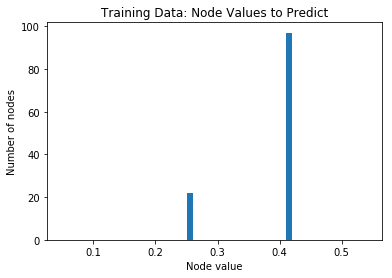

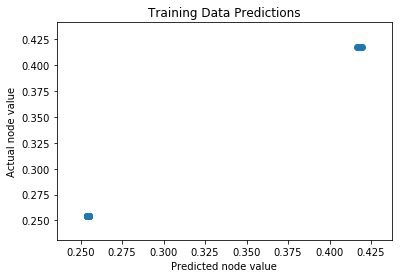

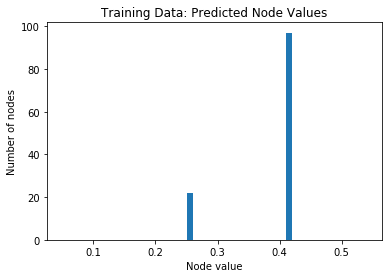

Training score:
tensor(1.6454e-07, grad_fn=<MeanBackward1>)
SpearmanrResult(correlation=0.6723976829732512, pvalue=5.599345947013748e-17)


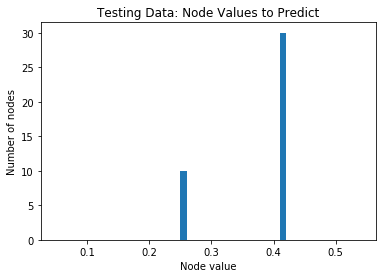

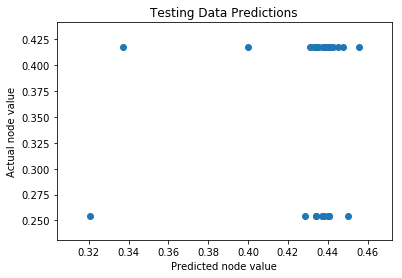

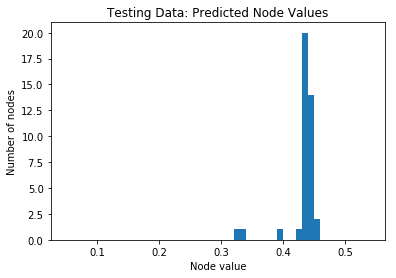

Testing score:
tensor(1.6454e-07, grad_fn=<MeanBackward1>)
SpearmanrResult(correlation=0.11003439112167819, pvalue=0.4990990920733779)


In [8]:
from sklearn.model_selection import train_test_split

xs, ys = formatData([testFiles[0]], '../data/'+name+'.tsp')
for x in xs:
    maxLen = max(maxLen, len(x))
for x in xs:
    while(len(x) < maxLen):
        x.append(0.0)

X_train, X_test, y_train, y_test = train_test_split(xs, ys)
print(len(X_train))
print(len(y_train))
print(len(X_train[0]))
print(len(X_test[0]))
#X_train = normalize(X_tr)
X_train_tens = Variable(torch.Tensor(X_train).float())
y_train_tens = Variable(torch.Tensor(y_train).float())
#X_test = normalize(X_te)
X_test_tens = Variable(torch.Tensor(X_test).float())
y_test_tens = Variable(torch.Tensor(y_test).float())

neur_net = My_Neural_Net(len(xs[0]))
neur_net.fit(X_train_tens,y_train_tens)
trainpreds = neur_net.predict(X_train_tens).detach()
plotPreds(y_train, trainpreds, neur_net)

testpreds = neur_net.predict(X_test_tens).detach()
plotPreds(y_test, testpreds, neur_net, True)